<a href="https://colab.research.google.com/github/fredymendezbustamante/ANALITICA_DE_DATOS/blob/main/Entrega_Final_2Analitica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega Final 
# Yessica Alejandra Gomez Rivera
#Jorge  Andres Noreña
# Freddy Alexander Mendez Bustamenate 

# Analitica de Datos/Andres Marino Alvarez Mesa 

2) Utilizando la base de datos de su preferencia, con al menos 4000 muestas, implemente y entrene un esquema de aprendizaje profundo y amplio. Realice un análisis completo en analítica de datos a partir del modelo diseñado y describa la información relevante encontrada y el posible conocimiento (producto, servicio) a generar en la práctica.

Importacion de librerias para poder utilizar la base de datos cifar10, en estas tambien importamos lo necesario para realizar el analisis requerido.

In [478]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

#Matriz de confusion
Utilizamos nuevamente el codigo para graficar la Matriz de confusion y comprobar la eficiencia del clasificador.

In [479]:
#%% Analisis exploratorio basico - base de datos housing
def pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):
    #exploratorio basico -> Normalizar + reduccion de dimensionalidad
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain_pre.index)
    
    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos
    
    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])
    yc = ytrain_pre[ind].reshape(-1)
    
    #reduccion de dimension con pca y tsne
    red_pca = PCA()
    #perplexity = np.round(0.75*np.sqrt(Np))
    #red_tsne = TSNE(n_components=2,perplexity = perplexity, n_iter = 250,verbose = 10)
        
    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz))
    #Xred_tsne = pd.DataFrame(red_tsne.fit_transform(Xz))
  
    #Relevancia por variabilidad
    var_ret = 0.95
    rel_vec,Mv,ind_rel = rel_pca(red_pca,var_ret)
    
    #graficar
    sval = 30
    #pca 2D
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = yc, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    #save_fig(path_img,"red_PCA2D")
    plt.show()
    
    #relevancia pca 2D     
    plt.imshow(rel_vec.reshape(w,h),cmap='jet')
    plt.ylabel('Relevancia PCA - eigenfaces')
    plt.title('RELEVANCIA PCA - eigenfaces, var_ret=%.2f' % (var_ret))
    plt.colorbar()
    #save_fig(path_img,"relevancia_PCA_eigenface")
    plt.show()
    #tsne 2D
    #Xred_tsne.plot(kind="scatter",x=0,y=1,
    #           c = yc, s = sval, label = col_sal,
    #          colormap = "jet",colorbar=True, sharex=False)    
    #plt.title('t-sne 2D - Perp.=%.2f' % perplexity)
    #plt.xlabel('Embebimiento - Dim. 1')
    #plt.ylabel('Embebimiento - Dim. 2')
    #save_fig(path_img,"tsne_2D")
    #plt.show()
    
    return True
#%% relevancia por variabilidad con pca
def rel_pca(red,var_exp):
    Mv = np.min(np.where(np.cumsum(red.explained_variance_ratio_)
                         >var_exp))
    M,P = red.components_.shape
    #print(P,M)
    rel_vec = np.zeros((P))
    for i in range(Mv):
        #print(i)
        rel_vec += abs(red.explained_variance_ratio_[i]*red.components_[i,:])
    
    rel_vec = rel_vec/sum(rel_vec)
    rel_vec = rel_vec - min(rel_vec)
    rel_vec = rel_vec/max(rel_vec)
    
    ind_rel = rel_vec.argsort()[::-1]
    return rel_vec, Mv,ind_rel

#%%  guardar figuras
#from google.colab import files
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 
    
import seaborn as sns

def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))

    #save_fig(path_img,title)
    plt.show()

    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
# Compute ROC curve and ROC area for each class
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
    #fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix_CNN(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    #plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    X = tf.cast(X,dtype=tf.float32)
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

Comencemos cargando el conjunto de datos CIFAR-10. Keras tiene una serie de funciones para cargar conjuntos de datos populares en keras.datasets.

In [480]:
cifar10 = keras.datasets.cifar10

In [481]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


El conjunto de datos CIFAR-10 consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba.


# Distribucion de datos
ahora mostramos todos los datos, para ver su estructura y poder clasificarlos.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


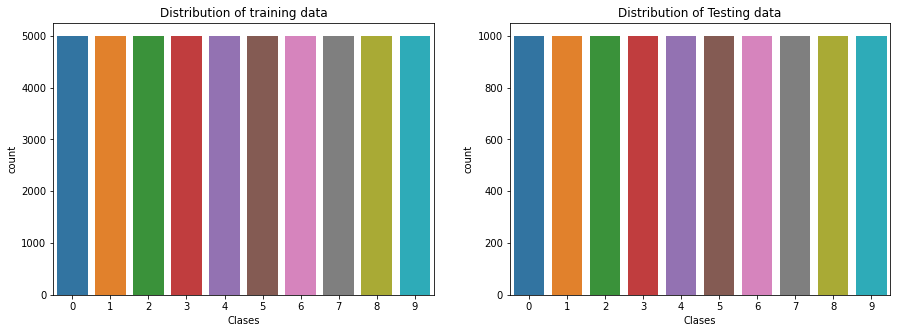

In [482]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Gráfico de recuento para el conjunto de entrenamiento
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Clases')
# Gráfico de recuento para el conjunto de prueba
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Clases')
plt.show()

In [483]:
nume_classes= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

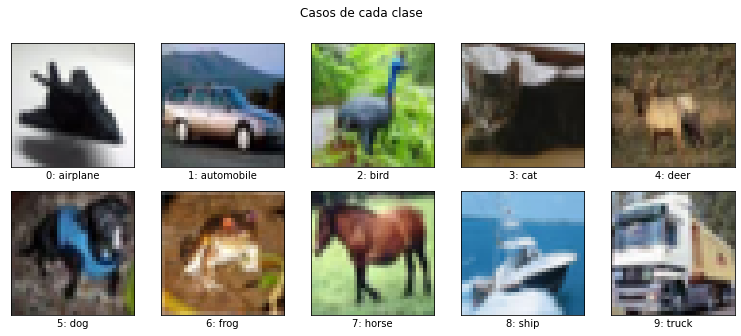

In [484]:

num_classes=len(nume_classes)
fig, ax = plt.subplots(figsize=(13,5), nrows=2, ncols=5, sharex=True, sharey=True,)
fig.suptitle('Casos de cada clase')
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(x_train[list(y_train).index(i),:,:,:], interpolation='nearest')
    ax[i].set_xlabel(str(i) + ': '+ nume_classes[i])

ax[0].set_xticks([])
ax[0].set_yticks([])
#plt.savefig('cimfar-10.png')
plt.show()

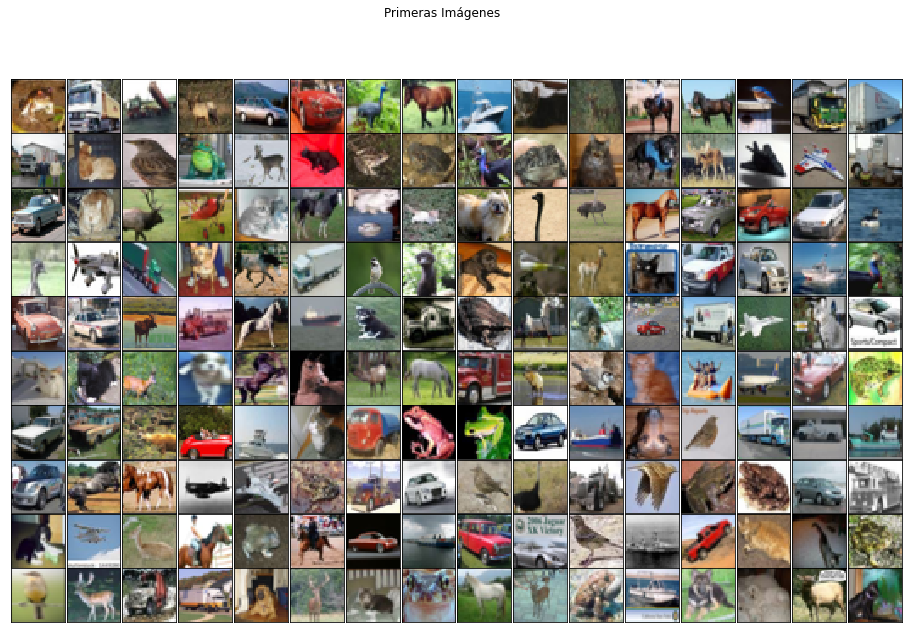

In [485]:
rows_imgs=10
cols_imgs=16
fig, ax = plt.subplots(figsize=(16,10), nrows=rows_imgs, ncols=cols_imgs, sharex=True, sharey=True,)
fig.suptitle('Primeras Imágenes')
ax = ax.flatten()
for i in range(rows_imgs*cols_imgs):
    ax[i].imshow(x_train[i], interpolation='nearest')
    idx = y_train[i][0]
    #ax[i].set_xlabel(str(idx)+': '+ names[idx])
ax[0].set_xticks([])
ax[0].set_yticks([])
#plt.savefig('cimfar-10-a.png')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.show()




Como podemos ver, cada clase contiene exactamente 6000 ejemplos (5000 para entrenamiento y 1000 para prueba).

El gráfico anterior es muy importante para el entrenamiento; por ejemplo, si solo tenemos 1000 muestras de la etiqueta 1, eso será un problema, el modelo encontrará dificultades para detectar la etiqueta 1 "menos precisión", por lo que eso no va a suceder, todo se verá bien. . Es importante conocer la distribución del conjunto de datos detrás de las diferentes clases porque su funcionamiento de nuestro modelo depende de ello.


## Pre-procesamiento de los datos
- codificacion de la etiquetas en formato one hote
-estandarizacion de los datos de entrenamiento.

In [486]:
#Particion entrenamiento y validacion

# Tamaño Xtrain 85%, Tamaño Xtest 15%
(X_train_full, Y_train_full), (X_test, y_test)= tf.keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, Y_train_full, test_size=0.15, random_state=42)
x_train, x_test, x_valid= X_train.astype('float32'), X_test.astype('float32'), X_valid.astype('float32')

In [487]:

from sklearn.preprocessing import OneHotEncoder
encoder= OneHotEncoder()

## Codificacion en One Hote.
y_train= encoder.fit_transform(y_train).toarray()
y_valid= encoder.transform(y_valid).toarray()
y_test= encoder.transform(y_test).toarray()

#y_train = y_train.reshape(-1,)
#y_test = y_test.reshape(-1,)
#y_valid = y_valid.reshape(-1,)

## Estandarizacion.
x_mean = x_train.mean(axis=0, keepdims=True)
x_std = x_train.std(axis=0, keepdims=True) + 1e-7
x_train = (x_train - x_mean) / x_std
x_valid = (x_valid - x_mean) / x_std
x_test = (x_test - x_mean) / x_std




x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape

((42500, 32, 32, 3),
 (42500, 10),
 (10000, 32, 32, 3),
 (10000, 10),
 (7500, 32, 32, 3),
 (7500, 10))

In [488]:
print(y_train[0])
print(y_test[0])
print(y_valid[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


#Modelo

Ahora definamos una red profunda adecuada.

En la primera etapa, nuestra red aprenderá 32 filtros convolucionales, cada uno de los cuales tiene un tamaño de 3 x 3. La dimensión de salida es la misma que la de la forma de entrada, por lo que será de 32 x 32 y la activación es relu, que es una forma sencilla de introducir la no linealidad; seguido de otros 32 filtros convolucionales, cada uno de los cuales tiene un tamaño de 3 x 3 y la activación también es relu. Después de eso, tenemos una operación de agrupación máxima con un tamaño de grupo de 2 x 2 y un abandono del 25%.
En la siguiente etapa de la tubería profunda, nuestra red aprenderá 64 filtros convolucionales, cada uno de los cuales tiene un tamaño de 3 x 3. La dimensión de salida es la misma que la de la forma de entrada y la activación es relu; seguido de otros 64 filtros convolucionales, cada uno de los cuales tiene un tamaño de 3 x 3 y la activación también es relu. Después de eso, tenemos una operación de agrupación máxima con un tamaño de grupo de 2 x 2 y un abandono del 25%.
Y la etapa final en la tubería profunda es una red densa con 512 unidades y activación relu seguida de una deserción al 50% y de una capa softmax con 10 clases como salida, una para cada categoría.
Ahora veamos la revisión del código de nuestra arquitectura.

In [489]:
#=======================================
### Limpiar ambiente
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
#=======================================

from functools import partial


#DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=1, activation='selu', padding="SAME")


model =  keras.models.Sequential([
                                  
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',input_shape=[32, 32, 3]),
    keras.layers.Dense(units=64,activation='selu',kernel_initializer="lecun_normal"),
    keras.layers.Conv2D(filters=32, kernel_size=3),
    keras.layers.Dense(units=64,activation='selu',kernel_initializer="lecun_normal"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),

    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    keras.layers.Dense(units=64,activation='selu',kernel_initializer="lecun_normal"),
    keras.layers.Conv2D(filters=64, kernel_size=3),
    keras.layers.Dense(units=64,activation='selu',kernel_initializer="lecun_normal"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),

    # FLATTERN => DENSE => RELU => DROPOUT
    keras.layers.Flatten(),
    keras.layers.Dense(units=512),
    keras.layers.Dense(units=64,activation='selu',kernel_initializer="lecun_normal"),
    keras.layers.Dropout(0.25),
    # un clasificador softmax
    keras.layers.Dense(units=10),
    keras.layers.Activation('softmax'),

])


In [490]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dense (Dense)                (None, 32, 32, 64)        2112      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        18464     
_________________________________________________________________
dense_1 (Dense)              (None, 30, 30, 64)        2112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        3

####Entrenamiento de modelos
Antes de preparar la red para la capacitación, debemos asegurarnos de agregar las siguientes cosas:

* Una función de pérdida: para medir qué tan buena es la red
* Un optimizador: para actualizar la red a medida que ve más datos y reducir el valor de pérdida
* Métricas: para monitorear el desempeño de la red

También tenga en cuenta que para el aumento de datos:

* Uno de los métodos más comunes para evitar el sobreajuste es el aumento de datos. Y sabemos que el sobreajuste ocurre generalmente cuando no tenemos suficientes datos para entrenar el modelo. Para evitar este problema de sobreajuste, necesitamos expandir artificialmente nuestro conjunto de datos. La idea es alterar los datos de entrenamiento con pequeñas transformaciones para reproducir las variaciones que ocurren cuando alguien está escribiendo un dígito.

* Las diferentes técnicas de aumento de datos son las siguientes: recortar, rotar, escalar, traducir, voltear, agregar ruido gaussiano a las imágenes de entrada, etc.

In [491]:
#sgd= keras.optimizers.SGD(learning_rate=0.01)
#learning_rate=0.001
#adam= keras.optimizers.Adam(learning_rate=0.001)
optimiz = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=optimiz, metrics=["accuracy"])


In [492]:
history = model.fit(x_train, y_train, batch_size=256, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
167/167 [==============================] - 7s 41ms/step - loss: 1.8819 - accuracy: 0.3494 - val_loss: 1.7704 - val_accuracy: 0.4045
Epoch 2/50
167/167 [==============================] - 7s 40ms/step - loss: 1.5053 - accuracy: 0.4680 - val_loss: 1.8853 - val_accuracy: 0.3796
Epoch 3/50
167/167 [==============================] - 7s 40ms/step - loss: 1.3680 - accuracy: 0.5202 - val_loss: 1.5032 - val_accuracy: 0.4924
Epoch 4/50
167/167 [==============================] - 7s 40ms/step - loss: 1.2851 - accuracy: 0.5523 - val_loss: 1.5245 - val_accuracy: 0.4776
Epoch 5/50
167/167 [==============================] - 7s 40ms/step - loss: 1.2333 - accuracy: 0.5697 - val_loss: 1.4189 - val_accuracy: 0.5283
Epoch 6/50
167/167 [==============================] - 7s 40ms/step - loss: 1.1921 - accuracy: 0.5846 - val_loss: 1.6335 - val_accuracy: 0.4612
Epoch 7/50
167/167 [==============================] - 7s 40ms/step - loss: 1.1621 - accuracy: 0.5955 - val_loss: 1.2142 - val_accuracy: 0.5799

Curvas de formación y validación.
Ahora observamos el proceso de entrenamiento y validación mediante la visualización del historial de ajuste. Esto nos permite saber rápidamente si nuestro modelo se ajusta a nuestros datos (sobreajuste, desajuste, convergencia del modelo, etc.)

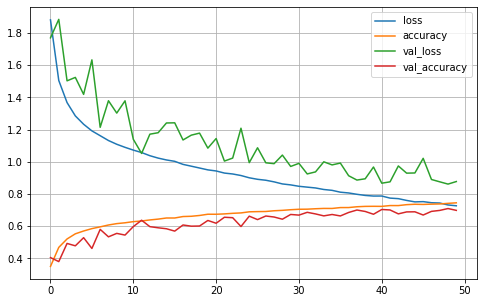

313/313 [==============================] - 1s 5ms/step - loss: 0.8722 - accuracy: 0.7068
Test loss: 0.7893886566162109
Test accuracy: 0.7382000088691711
[5 0] [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [493]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
score = model.evaluate(x_test, y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
X_new = X_test[:2] 
y_pred = model.predict_classes(X_new)
print(y_pred,y_test[:2])

pred = model.predict(x_test)


Como podemos ver, después de 50 épocas, la precisión de nuestro modelo no aumenta realmente. Pero nuestro modelo no se ajusta demasiado, esto puede ser causa de la red que se implemento, pues causa un aprendizaje no tan bueno para estos datos, pero aun teniendo este problema es capaz de identificar imagenes, no al 100% pero si con una precisión de un poco mas del 70%.


#### Matriz de confusión.
La matriz de confusión puede ser muy útil para ver los inconvenientes de su modelo. Trazamos la matriz de confusión de los resultados de la validación. Para una buena visualización de nuestra matriz de confusión, tenemos que definir la función.

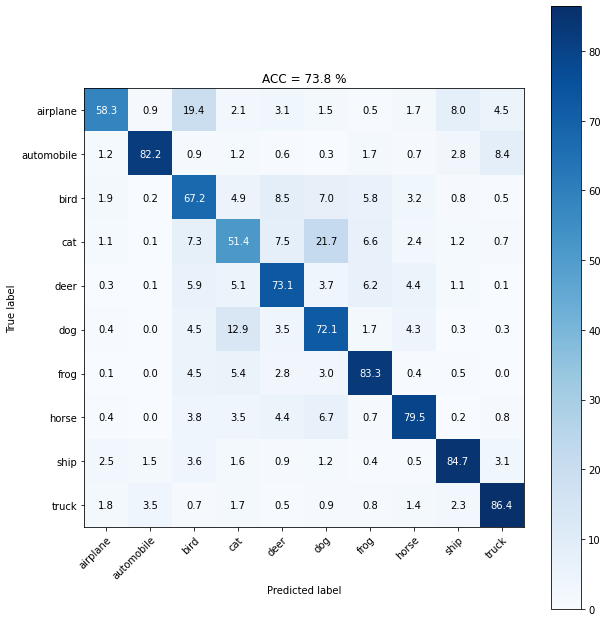

In [494]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # Utilice únicamente las etiquetas que aparecen en los datos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Gire las etiquetas de las marcas y establezca su alineación.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Recorra las dimensiones de los datos y cree anotaciones de texto.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

clases= np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
#clases= np.arange(10)
     

acc = accuracy_score(y,ypre_e)

plot_confusion_matrix(
                      y, ypre_e, 
                      classes=clases,
                      normalize=True,
                      title='ACC = %.1f %%' % (100*acc)
                      )

In [495]:
ypre_e= model.predict_classes(x_test)

In [496]:
y= encoder.inverse_transform(y_test).reshape(-1)


#### Modelo.
Se muestra el modelo con las capas que tiene implementadas.

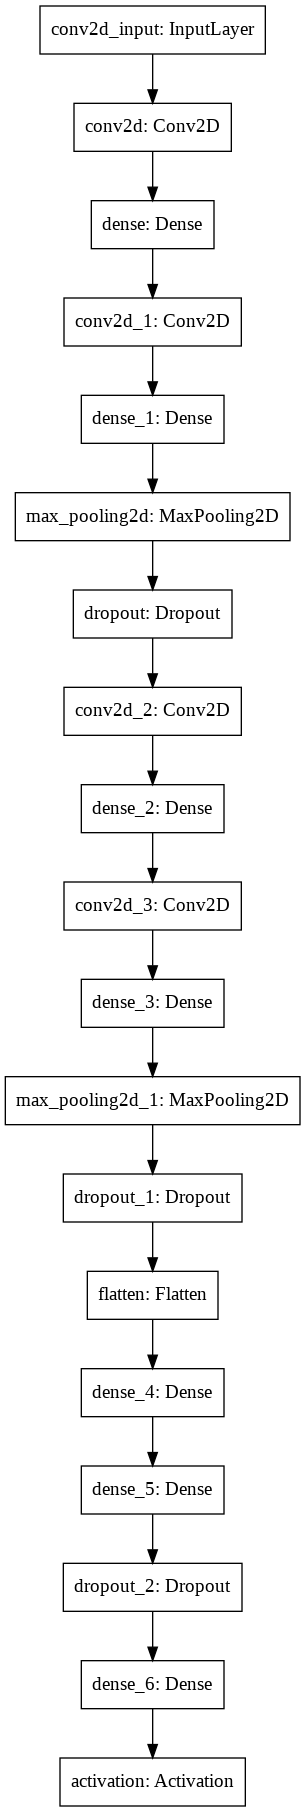

In [497]:
tf.keras.utils.plot_model(model)

In [498]:

Y_pred_classes = np.argmax(pred, axis=1) 

Y_true = np.argmax(y_test, axis=1)


#### Informe de clasificación
Esto nos permitirá evaluar el modelo con otras métricas (Precisión, Recuperación, Puntuación F1, etc ...)

In [499]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1000
           1       0.90      0.78      0.83      1000
           2       0.50      0.68      0.58      1000
           3       0.58      0.53      0.55      1000
           4       0.60      0.74      0.67      1000
           5       0.67      0.60      0.63      1000
           6       0.76      0.83      0.79      1000
           7       0.81      0.74      0.77      1000
           8       0.78      0.81      0.79      1000
           9       0.81      0.81      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



#### Verificación de predicciones.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

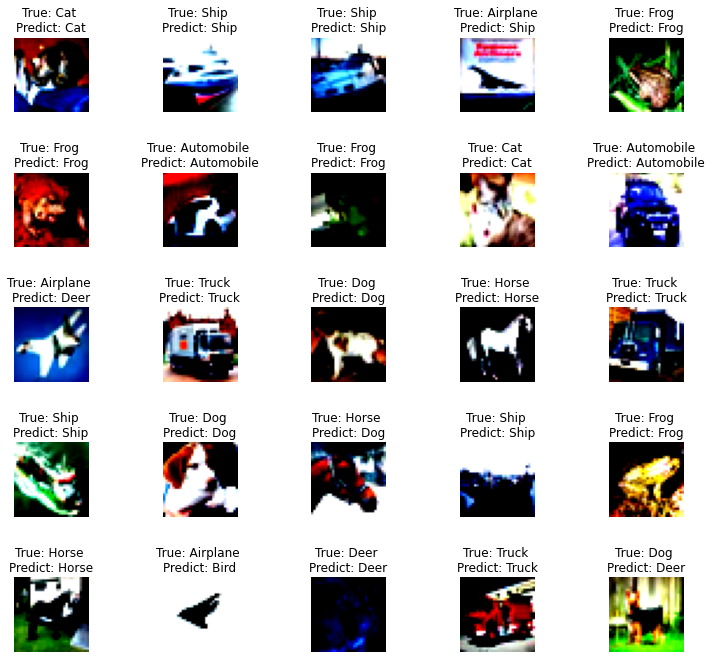

In [500]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#### Verificación de las predicciones incorrectas.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

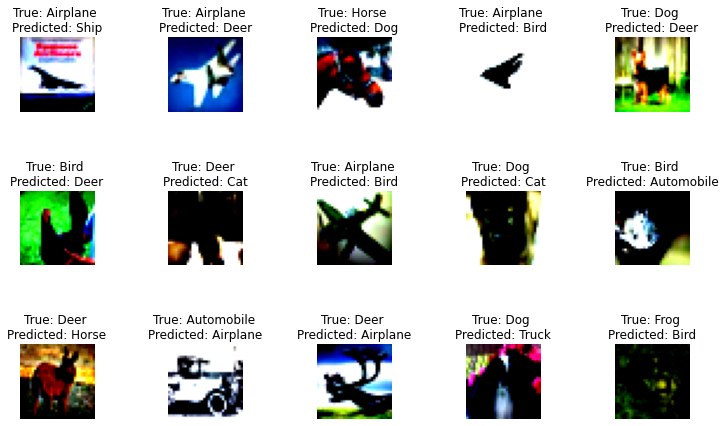

In [501]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#### Consulta los errores más importantes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

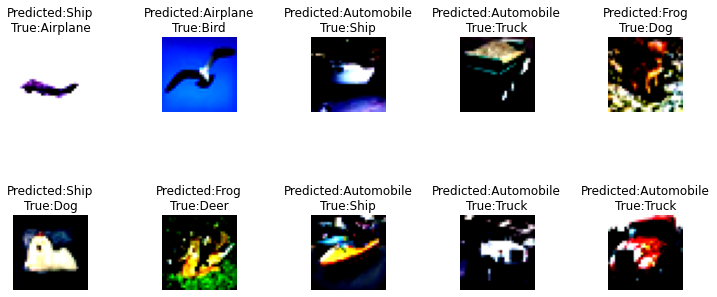

In [502]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilidades de los números predichos incorrectos
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Probabilidades pronosticadas de los valores verdaderos en el conjunto de errores
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Diferencia entre la probabilidad de la etiqueta predicha y la etiqueta verdadera
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Lista ordenada de los errores delta prob
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Mostrar los 10 errores principales
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

Probando el modelo con las imágenes de prueba en el conjunto de prueba.

se prueba si si se predice correctamente, en este caso, ingresamos una camion y veremos si el resultado de prediccion es el mismo.

In [503]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


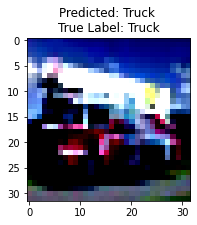

In [504]:
show_test(89)


como podemos visualizar al ingresar truck el resultado es el mismo lo que nos dice que la prediccion realizada es correcta y esta bien entrenado el sistema.

#### Guardar modelo y pesos

In [505]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Guardar modelo y pesos
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Puntuación modelo entrenado.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 2s 5ms/step - loss: 0.8722 - accuracy: 0.7068
Test loss: 0.872207522392273
Test accuracy: 0.7067999839782715


###Conclusión

No se obtuvo un error más bajo, pero tampoco una precición alta, Esto puede ser posible a la naturaleza de los datos ya que viendo algunas de las imagenes, podemos observar que son de muy baja resolucion como para almacenar figuras tan complejas en ella. Al hacer este almacenamiento cada pixel debe almacenar mucha informacion esto relacionandolo con su conectividad.
Un claro ejemplo de estos datos es la mala interpretacion de la clase de pajaros y aviones son muy parecidas cuando se enuentran en el aire ya que cuentan con un fisico similar, como las alas y el perfil en general, por lo que la red prediciria que posiblemente son la misma clase y realmente lo que los diferenciaria son los detalles de cada uno que se pierden en la baja resolucion de la imagen.


## Producto o servicio

* Se puede utilizar para el reconocimiento facial de personas.
* Visualizacion de objetos en los aeropuertos los cuales resultan despues de implementar rayos-x a las maletas, de esta manera verificar que si sean objetos que se puedan llevar. 
* Se puede aplicar en la mercadotecnia ya que se pueden utilizar estas herramientas en la búsqueda de imágenes similares o de la misma tipologia.

